# Optimizers, Hyperparameters, initializing parameters, weight decay/drop out ...

- 최적화에 사용되는 Optimizer에는 SDG 이외에도 여러가지가 있다. 경사하강법을 적절히 변형시킨 것들인데 학습목적에 맞는 것을 선택해야 한다.
- 학습 효율에 영향을 미치는 것들 중에서 학습 전에 조정해야 할 것들이 있다. Hyperparameter와 매개변수 초기화가 대표적이다.
- 학습 과정에서 오류를 발생시키는 것들 중 대표적인 것이 오버피팅 현상인데, 가중치 감소/드롭아웃 등의 정규화 기술이 있다.

## 1. Optimizers
대부분의 옵티마이저는 Gradient Descent 알고리즘의 다음 식을 변형한 것들이다. 
$$
\mathbf{W} \longleftarrow \mathbf{W} - \eta \frac{\partial L}{\partial \mathbf{W}}
$$
- $\eta$ : 학습률, $\mathbf{W}$ : 가중치 배열, $\frac{\partial L}{\partial \mathbf{W}}$ : 가중치에 대한 손실함수의 gradient
- 많은 손실이 날 수록(정답에서 많이 이탈할 수록, 경사가 심할 수록) 크게, 학습률에 비례하여, 손실이 줄어드는 방향으로, 가중치갱신이 일어난다.

### 1.1 SGD, Stochastic Gradient Descent
무작위로 미니배치를 선정하여 GD 하는 방식이다. 지금까지의 예제에서 사용했던 학습방법이다.
- 기울기에 따라 변동이 심하므로 학습 효율도 변동이 심하다.
- 비등방성anisotropy 함수의 경우 (예를 들어, $f(x,y) = \frac{1}{20} x^2 + y^2$)  탐색 방향에 따라 최적화 경로가 비효율적이 된다.
- plateau 에서 학습이 정체되기도 하는 단점이 있다.
- local minima를 벗어나지 못하고 학습이 멈추는 단점이 있다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from collections import OrderedDict
plt.style.use("seaborn")


In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

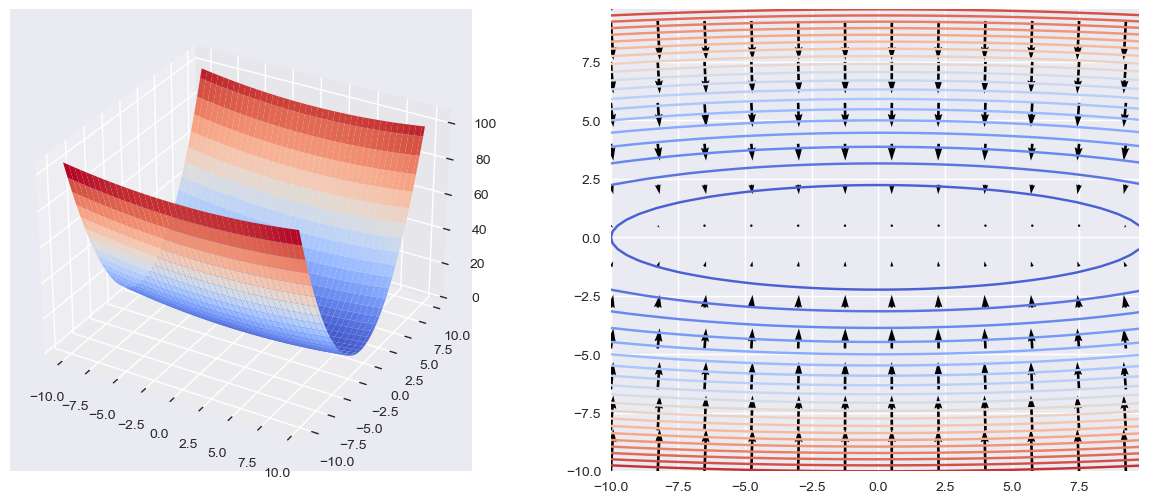

In [3]:
%matplotlib inline
f = lambda x, y: 1/20 * x**2 + y**2
f_ = lambda X: 1/20 * X[0]**2 + X[1]**2

x = np.arange(-10, 10, 0.25)
y = x.copy()
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

cmap = plt.get_cmap('coolwarm')
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot_surface(X, Y, Z, cmap=cmap)
ax2 = fig.add_subplot(122)
ax2.contour(X,Y, Z, 20, cmap=cmap)

from common.functions import num_gradient, num_gradient_without_batch
step = 7
X, Y = X[::step, ::step], Y[::step, ::step] 
pts = np.vstack((X.flatten(), Y.flatten())).T
dx, dy = num_gradient(f_, pts).T
ax2.quiver(X, Y, -dx, -dy, angles='xy', scale=250)
plt.show()

### 1.2 Momentum
위에서 보듯 가로축방향으로의 학습이 매우 비효율적임을 알 수 있다. 그래서 기울기의 누적치에 역비례하도록 학습량을 조정(누적된 기울기값이 클 수록 학습량은 작아지도록)하게 되는데 아래의 알고리즘을 가지는 Momentum이 그렇게 설계되었다.  
$$\begin{align*}
v &\longleftarrow -\Big(\eta\frac{\partial L}{\partial \mathbf{W}} - \alpha v \Big) =\alpha v - \eta\frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{W} &\longleftarrow \mathbf{W} + v 
\end{align*}$$
- $k$ 단계까지 거슬러 올라가 보면 다음과 같이 전개할 수 있다.
$$\begin{align*}
\mathbf{W}_{n+1} &= \mathbf{W}_n + v_n = \mathbf{W}_n + \Big(\alpha v_{n-1} - \eta\frac{\partial L}{\partial \mathbf{W}_{n}} \Big) \\
&= \mathbf{W}_n + \Big(\alpha \Big(\alpha (v_{n-2} - \eta\frac{\partial L}{\partial \mathbf{W}_{n-1}})\Big) - \eta\frac{\partial L}{\partial \mathbf{W}_{n}} \Big) \\
& \vdots \\
&= \mathbf{W}_n + \alpha^k v_{n-k} - \eta\sum_{i=1}^k \alpha^{i-1}\frac{\partial L}{\partial \mathbf{W}_{n-i+1}}  \\
&= \mathbf{W}_n + \alpha^n v_{0} - \eta\sum_{i=1}^n \alpha^{i-1}\frac{\partial L}{\partial \mathbf{W}_{n-i+1}} \\
&= \mathbf{W}_n - \eta\sum_{i=1}^n \alpha^{n-i}\frac{\partial L}{\partial \mathbf{W}_{i}} 
\end{align*}$$
- SGD는 현재 그래디언트값만이 갱신에 영향을 주는 반면, 모멘텀은 과거의 누적 갱신값이 현재 파라미터 갱신에 지수계수선형적으로($- \eta\sum_{i=1}^n \alpha^{n-i}\frac{\partial L}{\partial \mathbf{W}_{i}}$)영향을 주는 구조임을 알 수 있다. 
- 그래서 모멘텀이란 이름이 붙여졌는데, 관성Inertia(누적된 과거의 갱신값)을 고려한 결과 관성력에 의해 로컬 최적점을 지나쳐 학습이 이루어지도록 하여 SGD의 문제였던 로컬 극값에서 학습중단이 일어나는 확률을 줄이고 더 나은 최적점을 학습을 할 수 있는 가능성을 높인다.
- $\alpha$ 가 클 수록 학습 갱신에 저항(누적된 과거의 영향력)을 많이 받는다. 즉, 학습이 작은 스텝으로 이루어진다. 
- 물리학에서의 모멘텀처럼 $\alpha$ 를 질량 $v$ 를 속도로 하여 해석하면 $\alpha v$는 momentum 에 대응한다.
- 물론 $\alpha v$ 를 속도에 비례하는 저항력(damping force) 또는 저항모멘텀으로도 해석한다. 그래서 $\alpha < 1$ 이 되도록 설정한다.
- 요지는 질량이 클 수록 가속 $\frac{\partial L}{\partial \mathbf{W}}$ 에 따른 속도변화가 작듯이 학습 진행도 그렇게 되도록 설계되었다.
- 학습 갱신량 ($\eta\frac{\partial L}{\partial \mathbf{W}} - \alpha v$) 이 현재속도($v$) 에 역비례($-\alpha$) 하고 최적점 근처에서의 속도가 가장 크므로 최적점에 가까울 수록 갱신량이 줄어든다.

In [4]:
class Momentum:
    def __init__(self, lr=0.01, alpha=0.9) -> None:
        self.lr = lr      # learning rate
        self.v = None          # velocity
        self.alpha = alpha  # mass
    def update(self, params, grads):
        if self.v is None:  # v == 0 at starting point
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.alpha*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

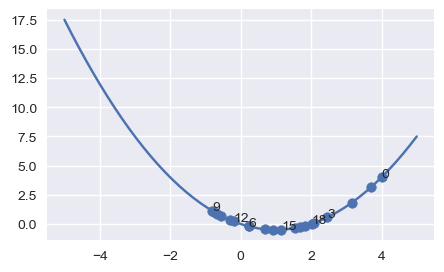

In [5]:
x = np.linspace(-5, 5)
f = lambda x: 0.5*x**2  - x
df = lambda x: x - 1
init = 4.0
params = {}
params['x'] = np.array([4.]) 
grads = {}
grads['x']  = 0
x_hist = []

mom = Momentum(lr=0.1, alpha=0.9)
for i in range(20):
    x_hist.append(*params['x'].copy())
    grads['x'] = df(params['x'])
    mom.update(params, grads)
y = f(np.array(x_hist))

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, f(x))
ax.scatter(x_hist, y)
for i, v in enumerate(x_hist):
    if i % 3 == 0:
        ax.annotate(i, (x_hist[i], y[i]))
plt.show()

### 1.3 Nesterov Accelerated Gradient, NAG
Nesterov Momentum은 현재 속도($v$) 대신에 현재 기울기로 계산된 다음 다음 속도를 저항속도로 사용하는 모멘텀이다. 즉,
$$
v \longleftarrow \alpha v - \eta\frac{\partial L}{\partial \mathbf{W}} \\
v \longleftarrow \alpha v - \eta\frac{\partial L}{\partial \mathbf{W}} \\
v \longleftarrow \alpha v - \eta\frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{W} \longleftarrow \mathbf{W} +  v
$$
한 단계로 풀이하면,
$$
\mathbf{W} \longleftarrow \mathbf{W} + \alpha \Big(\alpha (\alpha v -\eta \frac{\partial L}{\partial \mathbf{W}}) - \eta \frac{\partial L}{\partial \mathbf{W}}\Big) -\eta \frac{\partial L}{\partial \mathbf{W}}
$$

- Damping oscillation 운동을 하는 모멘텀 옵티마이저는 관성으로 인해 최적점을 지나쳐 가게 되어 있다. Nestrov 모멘텀의 경우 이 문제를 조금 줄일 수 있다.
- 아이디어는 다음과 같다. 파라미터 스페이스에서 모멘텀 옵티마이저보다 $-\eta\frac{\partial L}{\partial \mathbf{W}}$ 방향으로 옵티멈에 더 가깝게 파라미터를 옮기는 것이다. 최적점은 그것이 가리키는 방향에 존재할 것이기 때문이다. 
$$\begin{align*}
v_n &\longleftarrow \alpha v_{n-1} - \eta\frac{\partial L}{\partial \mathbf{W}} \Big|_{\mathbf{W} = \mathbf{W}_n + \alpha v_{n-1}} \\
\mathbf{W}_{n+1} &\longleftarrow \mathbf{W}_n + v_n
\end{align*}$$
- 이렇게 구성하면, $\mathbf{W}$ 점, $\alpha v$ 점, 기울기벡터 $ -\eta\frac{\partial L}{\partial \mathbf{W}}$ 의 연장선상에 있을 최적점의 삼각형을 떠올리면 알 수 있듯, Momentum에서의 평행사변형 꼴의 대각선  보다 더 가까워지긴 하지만, $\mathbf{W}$ 를 $\mathbf{W}_n + \alpha v_{n-1}$ 으로 변경하여 구해야 하므로 불필요한 임시 가중치를 중복계산하게 되는 번거로움이 생긴다. 그래서,
- 가중치는 변경하지 말고 $v$를 누적해서 (2번 더) 구함으로서 벡터를 기울기방향으로 더 기울어지도록 하는 방법을 사용한다. 즉, 벡터합의 평행사변형 꼴을 기울기 벡터 $-\eta\frac{\partial L}{\partial \mathbf{W}}$ 방향으로 더 납작하게 하는 것이다. 처음의 식처럼 말이다.![](NAG.png)

In [6]:
class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. 
    
    def __init__(self, lr=0.01, alpha=0.9):
        self.lr = lr
        self.alpha = alpha
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.alpha
            self.v[key] -= self.lr * grads[key]
            params[key] += self.alpha * self.alpha * self.v[key]
            params[key] -= (1 + self.alpha) * self.lr * grads[key]

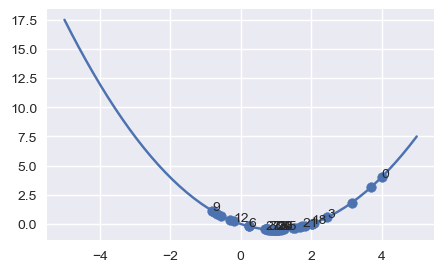

In [7]:
mom = Nesterov(lr=0.1, alpha=0.9)
for i in range(20):
    x_hist.append(*params['x'].copy())
    grads['x'] = df(params['x'])
    mom.update(params, grads)
y = f(np.array(x_hist))

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, f(x))
ax.scatter(x_hist, y)
for i, v in enumerate(x_hist):
    if i % 3 == 0:
        ax.annotate(i, (x_hist[i], y[i]))
plt.show()

### 1.4 AdaGrad
- step별 학습률 조정: 처음에는 큰 폭으로 학습하다가 최적점 가까이서는 작은 폭으로 학습하는 **학습률 감소 learning rate decay** 기술을 적용.
- 개별 매개변수별 조정: 개별 매개변수에 적응적adaptive 학습률을 조정하면서 학습을 진행한다.
$$\begin{align*}
\mathbf{h} &\longleftarrow \mathbf{h} + \frac{\partial L}{\partial \mathbf{W}} \odot \frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{W} &\longleftarrow \mathbf{W} - \eta \frac{1}{\sqrt{\mathbf{h}}}\frac{\partial L}{\partial \mathbf{W}}
\end{align*}$$

- $\mathbf{h}$는 개별 원소의 $\ell^2$-norm 제곱의 누적합 행렬이다. 따라서 gradient 누적 크기에 반비례하는 학습률로 학습하게 된다.
- 무한히 학습하는 과정에서 과거의 기울기를 제곱하여 계속 더해가므로 갱신강도가 약해져서(학습률이 너무 작아져 $\eta \frac{1}{\sqrt{\mathbf{h}}} \simeq 0$) 어느 순간 갱신이 안되는 문제가 있다.

### 1.5 RMSProp
- AdaGrad의 이런 문제를 해결하기 위해 추가로 forgetting factor $\left(1-\alpha\right)$를 도입한다.
- 과거의 기울기를 균일하게 더해가는 것이 아니라 과거보다 현재의 기울기를 크게 반영하도록 **지수이동평균Exponential Moving Average** 기법을 적용해 기하급수적으로 과거 기울기정보를 감소시키는 방식을 사용한다.
$$\begin{align*}
\mathbf{h} &\leftarrow \left(1 - \alpha \right)\mathbf{h} +  \alpha \frac{\partial L}{\partial \mathbf{W}} \odot \frac{\partial L}{\partial \mathbf{W}}\\
\mathbf{W} &\leftarrow \mathbf{W} - \eta \frac{1}{\sqrt{\mathbf{h}}} \frac{\partial L}{\partial \mathbf{W}}
\end{align*}$$

In [8]:
w1 = np.random.randint(-9, 10, (3, 4)).astype(np.float32)
w1 / (np.sqrt(w1 * w1) + 1e-7)

array([[ 1.,  1., -1.,  1.],
       [-1., -1., -1.,  1.],
       [ 1., -1.,  1., -1.]], dtype=float32)

In [9]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

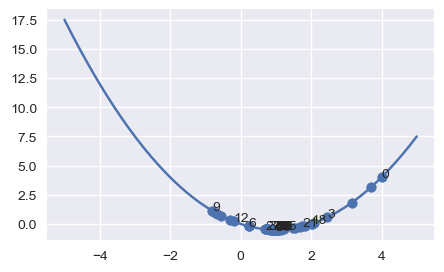

In [10]:
mom = AdaGrad(0.1)
for i in range(20):
    x_hist.append(*params['x'].copy())
    grads['x'] = df(params['x'])
    mom.update(params, grads)
y = f(np.array(x_hist))

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, f(x))
ax.scatter(x_hist, y)
for i, v in enumerate(x_hist):
    if i % 3 == 0:
        ax.annotate(i, (x_hist[i], y[i]))
plt.show()

In [11]:
class RMSprop:
    """
    RMSprop은 AdaGrad 에서 h 갱신 부분을 decay_rate으로 웨이팅 처리 해준 것만 다르다.
    즉, AdaGrad에서는 h <- h + grads * grads 로 갱신되던 감소팩터 h를, 
    RMSprop에서는 h <- (decay_rate) * h + (1 - decay_rate) * grads * grads 로 웨이팅
    처리하여 현재와 과거의 비중을 달리 하여 감소팩터 h를 결정한다.
    """

    def __init__(self, lr=0.01, decay_rate=0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) 

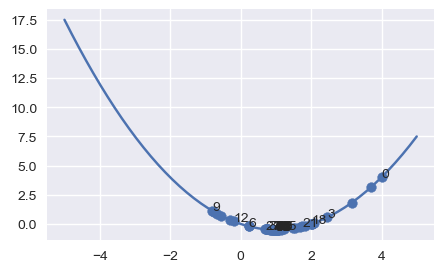

In [12]:
mom = RMSprop(0.1)
for i in range(20):
    x_hist.append(*params['x'].copy())
    grads['x'] = df(params['x'])
    mom.update(params, grads)
y = f(np.array(x_hist))

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, f(x))
ax.scatter(x_hist, y)
for i, v in enumerate(x_hist):
    if i % 3 == 0:
        ax.annotate(i, (x_hist[i], y[i]))
plt.show()

### 1.6 Adam
- momentum은 과거 데이터를 반영하여 학습률을 조정하는 이점이 있었고, AdaGrad는 매개변수의 원소마다 적응적으로 갱신강도를 조정하는 이점이 있었는데, 이 두 가지 이점을 살려 결합한 것이 Adam 이라 할 수 있다.
- 또한 하이퍼파라미터의 '편향 보정'이 진행된다는 특징이 있다.
![Adam pseudo code](./adam_optimizer.png)
- 계산 과정:
**while** $\theta_{t}$ not converged **do**:  
  1) $\quad t \leftarrow  t + 1$  
  2) $\quad g_t \leftarrow \nabla_{w}L_{t}(\omega_{t-1}) $    
  3) $\quad m_t \leftarrow \beta_{1}\cdot m_{t-1} + (1 - \beta_{1})\cdot g_t$  
  4) $\quad v_t \leftarrow \beta_{2}\cdot v_{t-1} + (1 - \beta_{2})\cdot g^{2}_{t}$  
  5) $\quad \hat{m}_{t} \leftarrow \frac{m_t}{1 - \beta^{t}_1}$  
  6) $\quad \hat{v}_{t} \leftarrow \frac{v_t}{1 - \beta^{t}_2}$  
  7) $\quad \omega_t \leftarrow \omega_{t-1} - \frac{\mu \cdot \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$
  
  - 2) Get gradients at timestep t
  - 3) Update biased first moment estimate(Momentum)
  - 4) Update biased second raw moment estimate(RMSprop)
  - 5) Compute bias-corrected first moment estimate  
        1에 가까운  $\beta$ 값으로 편향된 first moment estimate을 보정한다.
  - 6) Compute bias-corrected second raw moment estimate
  - 7) Update parameter


### optimizers의 계보
| |SGD| |
|:--:|:--:|:--:|
|$\swarrow$||$\searrow$|
|모멘텀 적용| |학습률 조정|
|momentum||AdaGrad|
|$\downarrow$|$\searrow$|$\downarrow$|
|NAG|EWA momentum|RMSprop|
||$\downarrow$|$\swarrow$|
||Adam||

In [13]:
class Adam:

    """
    Adam (http://arxiv.org/abs/1412.6980v8)
    Require: lr: stepsize, or learning rate
    Require: beta1, beta2 \in [0, 1): exponential decay rate for the moment estimates
    Require: L(w): Stochastic objective function with parameters w
    Require: w0 : initial parameter vector
             m0 <- 0 (initialize 1st moment vector)
             v0 <- 0 (initialize 2nd moment vector)
             t  <- 0 (initialize timestep)              
    """

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        # moment estimates의 지수감소율
        self.beta1 = beta1  
        self.beta2 = beta2  
        
        self.iter = 0       # Stepsize counter
        
        self.m = None       # 1st moment vector
        self.v = None       # 2nd moment vector
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        
        # 논문의 alpha
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key]) # 3
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key]) # 4
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


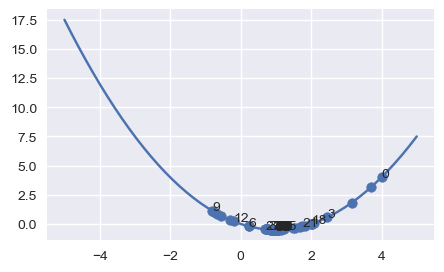

In [14]:
mom = Adam(0.1)
for i in range(20):
    x_hist.append(*params['x'].copy())
    grads['x'] = df(params['x'])
    mom.update(params, grads)
y = f(np.array(x_hist))

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, f(x))
ax.scatter(x_hist, y)
for i, v in enumerate(x_hist):
    if i % 3 == 0:
        ax.annotate(i, (x_hist[i], y[i]))
plt.show()

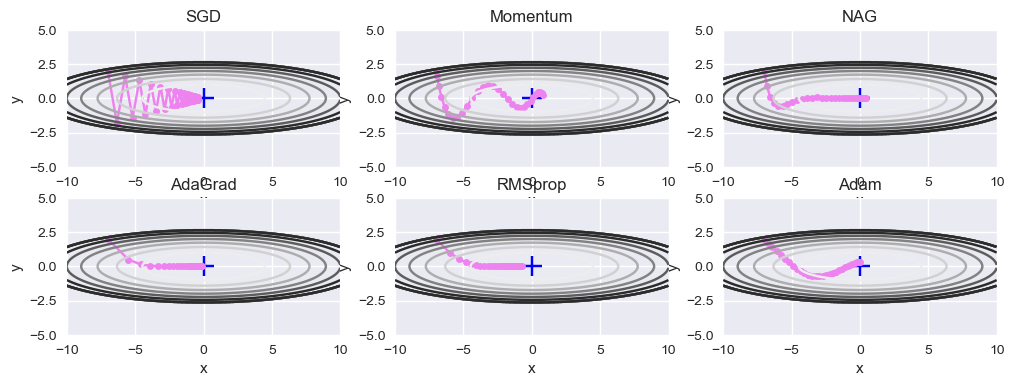

In [15]:
f = lambda x, y: 1/20.0*x**2 + y**2
df = lambda x, y: (1/10.0*x, 2*y)

init_p = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_p[0], init_p[1]
grads = {}
grads['x'], grads['y'] = 0, 0

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["NAG"] = Nesterov(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["RMSprop"] = RMSprop(lr=0.1, decay_rate=0.99)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

fig = plt.figure(figsize=(12, 4))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_p[0], init_p[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
        
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    
    # remove outer contours 
    mask = Z > 7
    Z[mask] = 0
    
    # draw graphs
    axes = fig.add_subplot(2, 3, idx)
    idx += 1
    axes.plot(x_history, y_history, 'o-', markersize=5, color='violet')
    axes.set_aspect('equal')
    axes.contour(X, Y, Z)
    axes.set_ylim(-5, 5)
    axes.set_xlim(-10, 10)
    axes.scatter(0, 0, s=200, marker='+', color='b')
    
    axes.set_title(key)
    axes.set_xlabel('x')
    axes.set_ylabel('y')
    
plt.show()   

===========iteration:0===========
SGD:2.3108946569369957
Momentum:2.445120452357541
AdaGrad:2.355191906518166
Adam:2.2037806670014604
===========iteration:100===========
SGD:1.648562534517993
Momentum:0.24648533041175485
AdaGrad:0.12018868581215905
Adam:0.19073523926715574
===========iteration:200===========
SGD:0.8406783743024171
Momentum:0.2857324120232698
AdaGrad:0.08782207261105071
Adam:0.17206846485487096
===========iteration:300===========
SGD:0.490531764263611
Momentum:0.22708705982102267
AdaGrad:0.10802705974640932
Adam:0.17842065130648815
===========iteration:400===========
SGD:0.5510611253734814
Momentum:0.28471714962958644
AdaGrad:0.13693237050555085
Adam:0.183671473216862
===========iteration:500===========
SGD:0.32979213461754747
Momentum:0.09634569989931836
AdaGrad:0.054159797667984795
Adam:0.09151710912685991
===========iteration:600===========
SGD:0.35545839892649955
Momentum:0.16407146208009166
AdaGrad:0.054474964161318966
Adam:0.0935323276319576
===========iteration:7

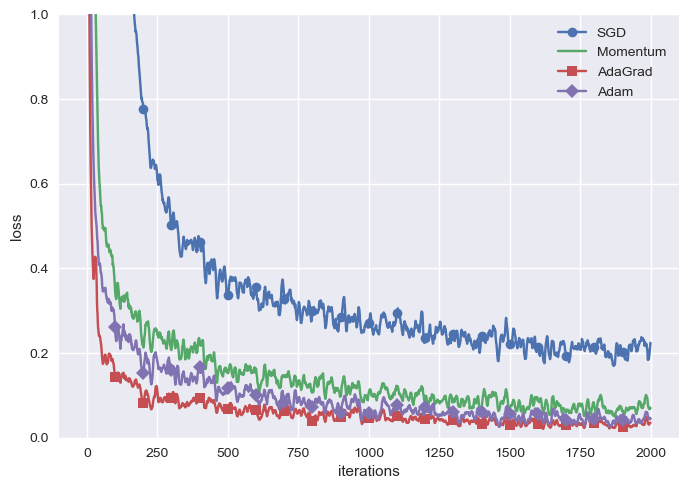

In [16]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 2. 가중치의 초기값
- 신경망 학습 성패가 갈리는 중요한 요인.
### 2.1 초기값 설정 Criteria
#### 2.1.1 무작위 설정
- 초기값을 0으로 하면(또는 균일한 값으로 설정하면) 오차역전파과정에서 모든 가중치 값이 똑같은 값으로 갱신되므로 가중치를 여럿 두는 의미가 사라진다.
- 따라서 고른 가중치가 나오는 결과를 피하기 위해 초기값을 무작위로 설정한다.
#### 2.1.2 작은 값에서 시작
- 뒤에 나오는 오버피팅을 억제하여 범용 성능을 높이는 가중치 감소 기법이 있다.
- 가중치 매개변수의 값이 작아지도록 학습하는 방법이다.
- 따라서 가중치 감소의 목적을 달성하기 위해 초기값도 작은 값에서 시작한다.
#### 2.1.3 활성화 함수에 맞는 초기값을 사용한다.
- 초기값 분포 크기(표준편차크기)에 따라 vanishing gradient기울기 소실, poor representation표현력 제한 문제가 발생한다.
    - sigmoid/tanh함는 0 근처에서 선형에 가깝고 양 극으로 갈 수록 평탄화 된다. 그러므로 분포가 넓은 경우(표준편차크기가 큰 경우) 0/1, -1/1 값을 출력하는 입력이 많아진다. 이 때의 gradient는 평탄화되어 0에 가까워지므로 거의 학습이 이루어 지지 않는 vanishing gradient문제가 생긴다.
    - 반면, 분포가 좁은 경우(표준편차가 너무 작은 경우), 1/2, 0 값을 출력하는 입력, 즉 중심인 0값 근처의 입력이 많아진다. 이 때는 vanising gradient문제는 발생하지 않지만, 여러 가지의 가중치를 두는 의미가 없어져 마치 단일 가중치로 계산하는 것과 별 차이 없게 되는 poor representation표현력 제한 문제가 생기게 된다.
    - 이런 문제를 해결하기 위해 sigmoid/tanh함수가 활성화함수일 경우, Xavier 초기값을 사용한다. Xavier 초기값은 표준편차가 $\frac{1}{\sqrt{n}}$ (n 개의 nodes)인 분포를 사용한다.
- Relu함수가 활성화함수일 경우, He 초기값을 사용한다. He 초기값은 표준편차가 $\sqrt{\frac{2}{n}}$ 인 정규분포를 사용한다.                                      
- 은닉층의 활성화값(계층 사이를 흐르는 데이터) 분포를 살펴보는 것이 도움이 된다.
    - 레이블에 대응하는 예측값 분포를 히스토그램으로 나타낸다.   

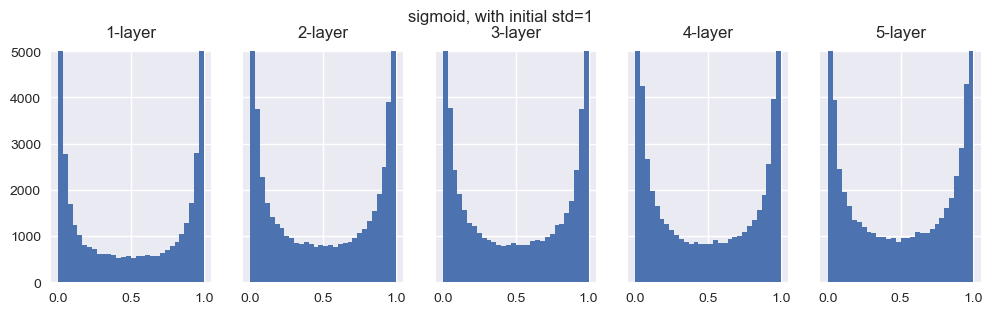

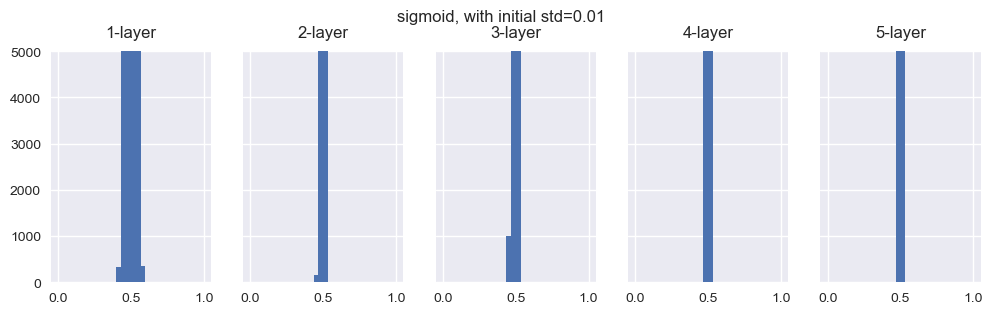

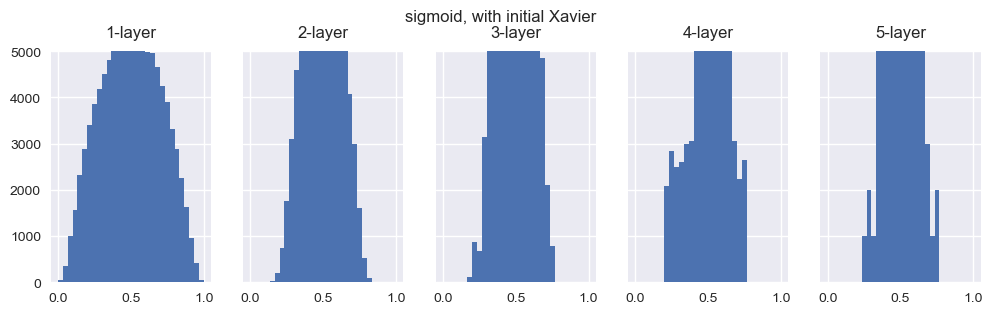

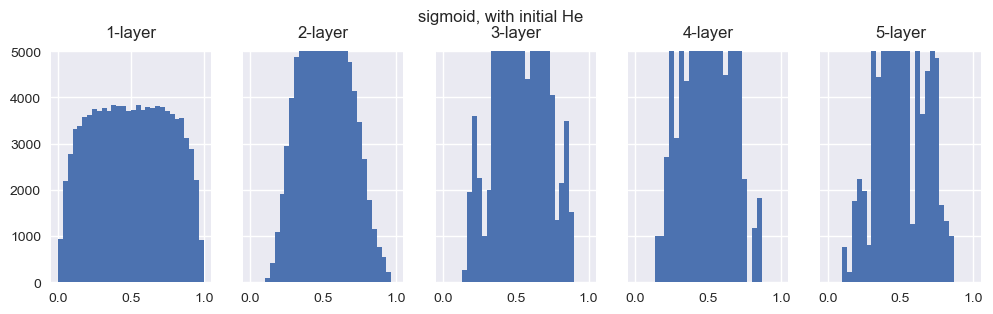

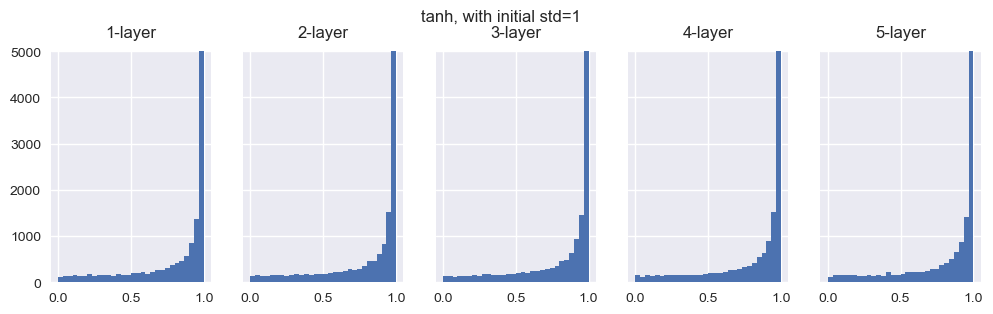

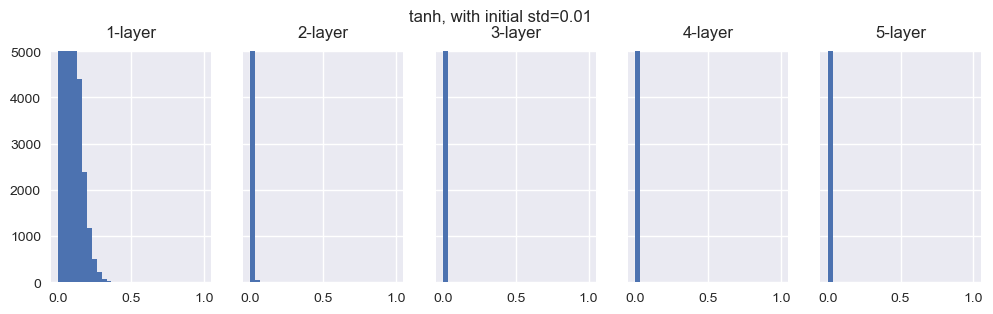

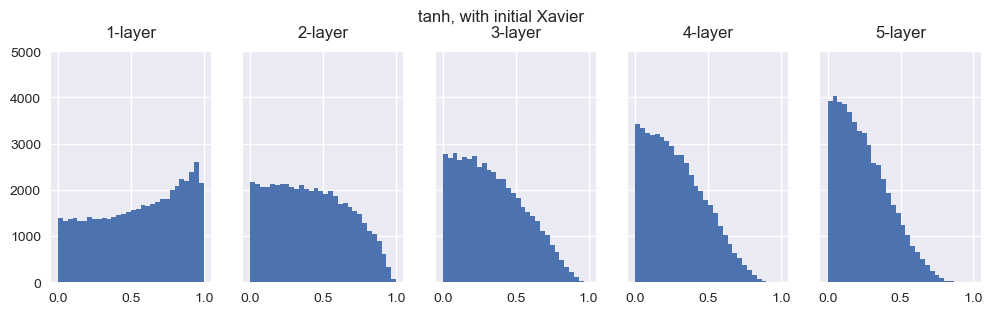

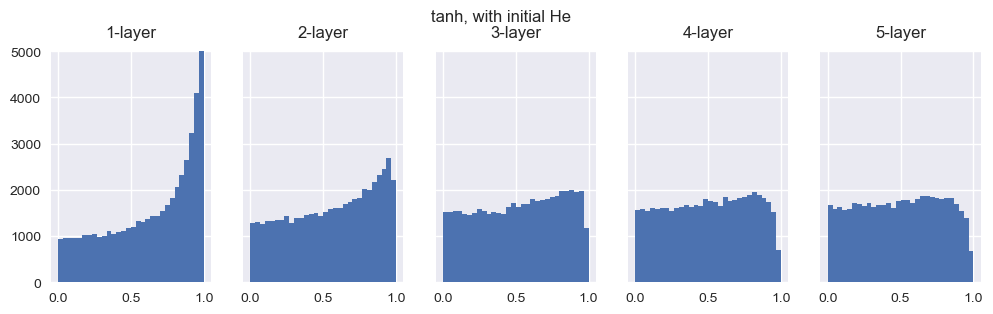

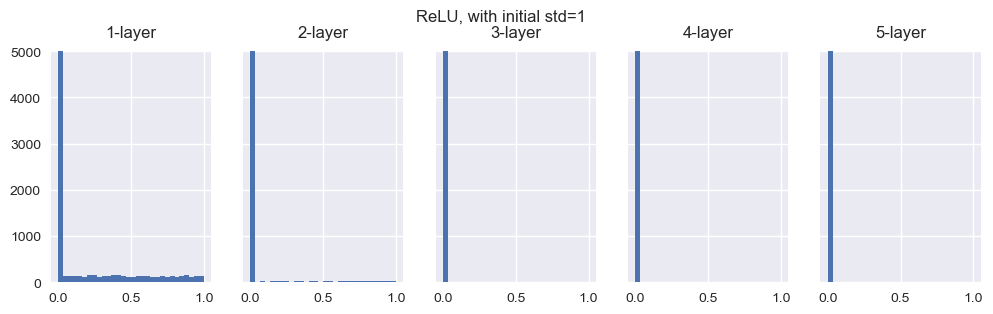

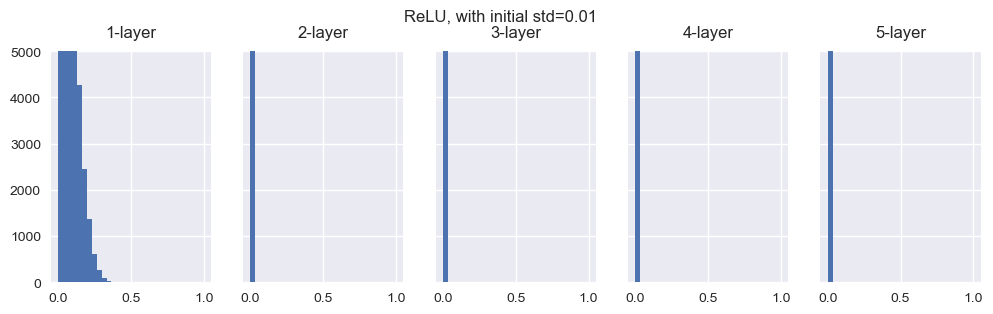

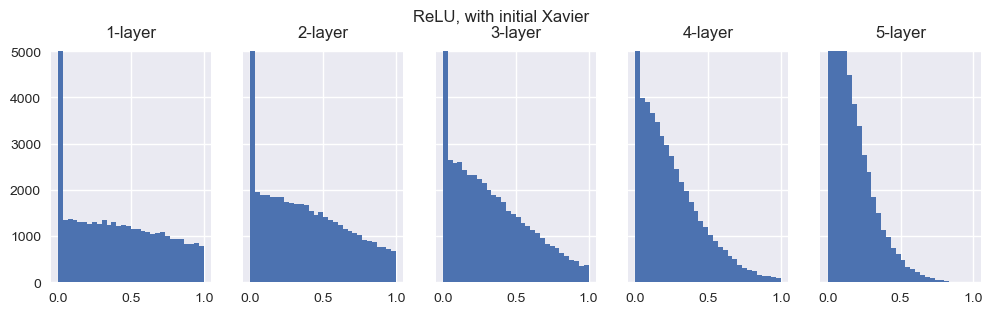

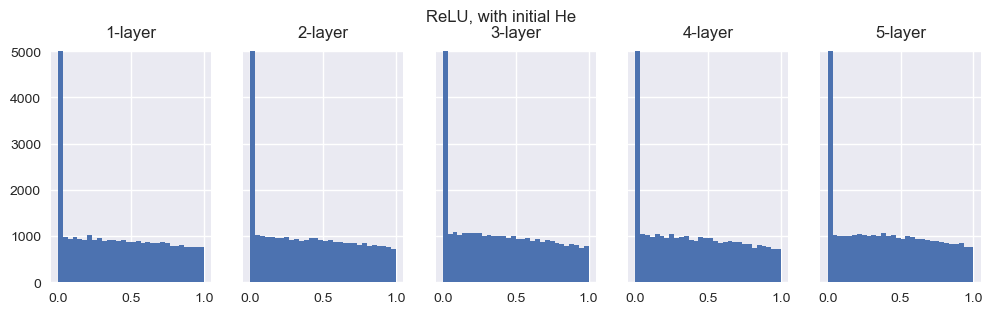

In [17]:
# 초기값 실험
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)

input_data = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

activation_fnc = {
    "sigmoid": lambda x: sigmoid(x),
    "tanh": lambda x: tanh(x),
    "ReLU": lambda x: ReLU(x),
}
initial_deviations = {
    # 초깃값을 다양하게 바꿔가며 실험해보자！
    "std=1": 1,
    "std=0.01": 0.01,
    "Xavier": np.sqrt(1.0 / node_num), # Xavier
    "He": np.sqrt(2.0 / node_num) # He
}


for f in activation_fnc.keys():
    
    for dev in initial_deviations.keys():
        x = input_data # 초기 설정별로 같은 값으로 유지

        for i in range(hidden_layer_size):
            if i != 0:
                x = activations[i-1]
            w = np.random.randn(node_num, node_num) * initial_deviations[dev] # layer마다 랜덤생성
            a = np.dot(x, w)
            z = activation_fnc[f](a)
            activations[i] = z
        # histogram
        fig, axes = plt.subplots(1, len(activations), figsize=(12, 3), sharey=True)
        fig.suptitle(f"{f}, with initial {dev}", va='baseline')
        for i, a in activations.items():
            axes[i].set_title(str(i+1) + "-layer", pad=10)
            axes[i].hist(a.flatten(), 30, range=(0, 1))
            axes[i].set_ylim(0, 5000)
plt.show()

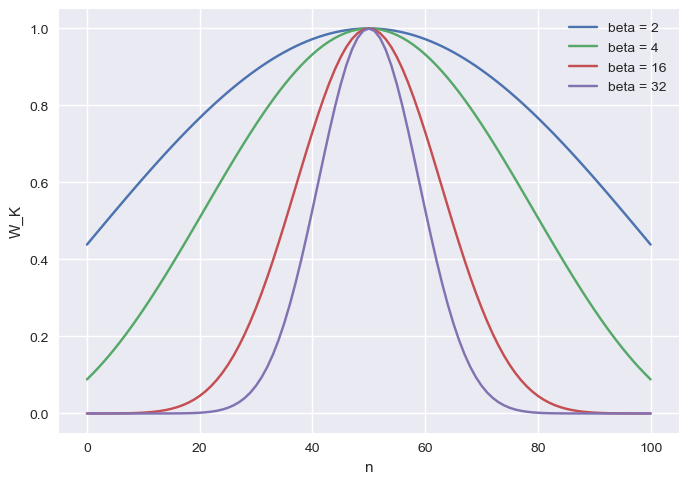

In [18]:
# smoothing and numpy convolve
# https://glowingpython.blogspot.com/2012/02/convolution-with-numpy.html
import pylab
beta = [2, 4, 16, 32]

pylab.figure()
for b in beta:
    w = np.kaiser(101, b)
    pylab.plot(range(len(w)), w, label="beta = "+ str(b))
pylab.xlabel('n')
pylab.ylabel('W_K')    
pylab.legend()
pylab.show()

In [19]:
def smooth(x, beta):
    """ kaiser window smoothing """
    window_len = 11
    # extending the data at beginning and the the end
    # padding to apply the window at the borders
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]] # concat along axis=0
    w = np.kaiser(window_len, beta)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]    

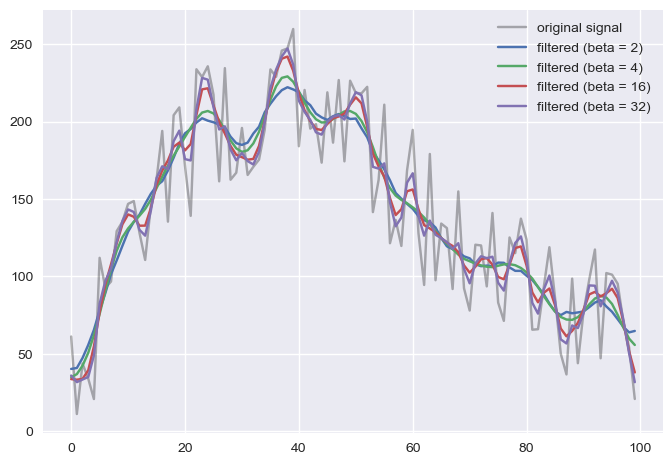

In [20]:
# random data generation
y = np.random.random(100)*100 
for i in range(100):
 y[i]=y[i]+i**((150-i)/80.0) # modifies the trend

# smoothing the data
pylab.figure(1)
pylab.plot(y,'-k',label="original signal",alpha=.3)
for b in beta:
 yy = smooth(y,b) 
 pylab.plot(yy,label="filtered (beta = "+str(b)+")")
pylab.legend()
pylab.show()

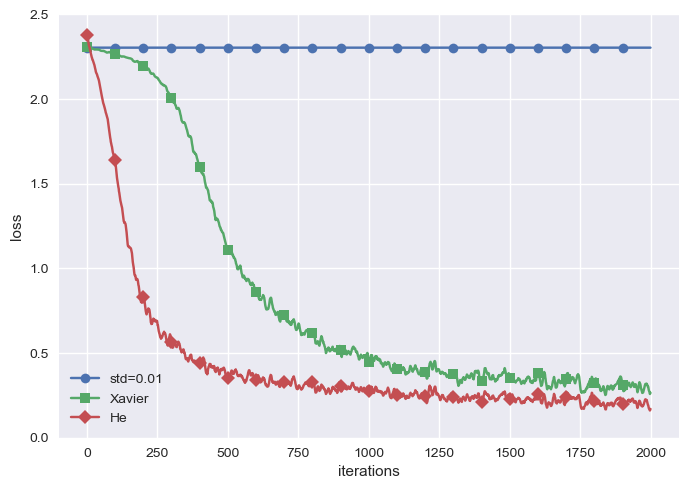

In [21]:
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        # print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            # print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()


## 3. Batch Normalization
- 2015년에 제안된 방식으로 성능 개선효과가 높은 기술이다.
- 학습속도를 높인다.
- 초기값 의존도를 낮춘다.
- 오버피팅을 억제한다.  
  
|    |    |배치정규화층 추가|    |    |  
|:--:|:--:|:--------------:|:--:|:--:|  
|Affine|->|Batch Norm|->|ReLu|  

- 분산(scale) 파라미터 $\gamma$와 평균(displacement) 파라미터 $\beta$를 학습파라미터로서 학습하며(초기값은 각각 1, 0) 효율적인 분포를 찾아가며 학습하게 된다. 
$$
\hat{A} = \gamma A_n + \beta
$$
- 따라서, 갱신해야 할 파라미터는 $\mathbf{W}$, $\mathbf{b}$, $\gamma$, $\beta$ 가 된다.
- For $(m, f)$ shaped input $A$ returned from the Affine layer
$$\begin{align*}
A_{i\cdot} &\equiv (A_{i1}, A_{i2}, \ldots, A_{if}) \\
\mu_B &\leftarrow \frac{1}{m}\sum_{i=1}^{m} A_{i\cdot} \\
\sigma_{B}^{2} &\leftarrow \frac{1}{m}\sum_{i=1}^{m}(A_{i\cdot} - \mu_B)^2 \\
A_n &\leftarrow \frac{A - \mu_B}{\sqrt{\sigma_{B}^{2} + \epsilon}}
\end{align*}$$  

- gradient는 다음 결과가 된다.
$$\begin{align*}
\partial_{\gamma} &= A_n\partial_{\hat{A}}  \\
\partial_{\beta} &= \partial_{\hat{A}}
\end{align*}$$

- $A$에서 $A_n$으로 이어지는 계산그래프에는 여러번 Broadcasting이 적용되었다. 
- 앞서 Affine 모델에서도 보았듯 Broadcasting(B-node)은 repeat노드로 볼 수 없고, 
- 따라서, 순전파 때에 B-node 직전 입력값에 해당하는 gradient 값을 산출할 필요가 있을 때만  역전파 결과로 출력값의 `mean(axis=0)` 로 하든가(이 때 repeat노드의 역전파 결과는 합산으로 나오는데, 평균과는 scale만 다르므로 본질적으로 문제될 것은 없다.), 
- 산출할 필요가 없는 중간결과일 뿐이라면 Broadcating 출력값과 동일한 모양을 유지시킨다.

|||Broadcasting||
|:--|:--|:--:|:--|
|순전파|$\mathbf{b} \rightarrow$| B-node | $\rightarrow \mathbf{B}$|
|역전파|$\partial_{\mathbf{b}} \leftarrow$| dB-node | $\leftarrow \partial_{\mathbf{B}}$ |  

e.g.  
$$
\partial_{A} = \frac{1}{m}\partial_{\mu} = \frac{1}{m}\partial_{\Mu}
$$

- 첫 째 등호에서 Broadcasting 이 적용되어 $\mu$의 shape (f,)을 $A$의 shape (m, f)으로 맞추어 주므로, $\partial_{\Mu}$ 의 shape (m,f)로 복원된다. 
- 이 때 번거로움을 줄여, 바로 둘 째 등호의 결과를 사용한다.

In [22]:
# Batch Normalization
# 연습1
A = np.array([[1, -1, 1],
              [2, -2, 1],
              [3, -3, 2],
              [4, -4, 2],
              [5, -5, 4]])
gamma = np.array([np.sqrt(2), 2*np.sqrt(2), np.sqrt(30)]) # 확대
beta = np.array([2, 4, 5]) # 이동

Ac = A - A.mean(axis=0)
var = np.mean(Ac**2, axis=0)
std = np.sqrt(var + 10e-7)
An = Ac/std
A_hat = gamma * An + beta
A_hat.round()

array([[ 0.,  8.,  0.],
       [ 1.,  6.,  0.],
       [ 2.,  4.,  5.],
       [ 3.,  2.,  5.],
       [ 4.,  0., 15.]])

In [23]:
# 연습2
A = np.array([[-2, 0, 4],
              [-1, 1, 2],
              [0, 2, 2],
              [1, 3, 1],
              [2, 4, 6]])
gamma = np.array([np.sqrt(2), 2*np.sqrt(2), 4*np.sqrt(5)])
beta = np.array([2, 4, 10])
mu = A.mean(axis=0)
Ac = A - mu
var = np.mean(Ac**2, axis=0)
std = np.sqrt(var + 10e-7)
An = Ac/std
A_hat = gamma*An + beta
A_hat.round()

array([[ 0.,  0., 15.],
       [ 1.,  2.,  5.],
       [ 2.,  4.,  5.],
       [ 3.,  6.,  0.],
       [ 4.,  8., 25.]])

In [24]:
#  연습3
dout = np.array([
    [1, -1, 4],
    [-1, 1, -4],
    [1, -1, 4],
    [-1, 1, -4],
    [1, -1, 4]
])
dLdbeta = dout
dLdgamma = An * dout
dLdgamma.sum(axis=0), dLdgamma.mean(axis=0)

(array([ 0.        ,  0.        , 13.41640577]),
 array([0.        , 0.        , 2.68328115]))

In [25]:
class BatchNormalization:
    """각 층의 활성화값이 적당히 분포되도록 조정하는 layer이다.
    """
    def __init__(self, gamma, beta, momentum=0.9, 
                 running_mean=None, running_var=None) -> None:
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱계층은 4차원, 완전연결계층은 2차원
        
        # test에 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var
        
        # backward 에서 사용할 중간 데이터
        self.batch_size = None
        self.ac = None
        self.var = None
        self.std = None
        self.an = None
        self.dgamma = None
        self.dbeta = None
        
    def forward(self, a, train_flg=True):
        self.input_shape = a.shape
        if a.ndim !=2:
            N, C, H, W = x.shape
            a = a.reshape(N, -1)
        
        out = self.__forward(a, train_flg)
        
        return out.reshape(*self.input_shape)
    
    def __forward(self, a, train_flg=True):
        if self.running_mean is None:
            N, D = a.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
            
        if train_flg:
            mu = a.mean(axis=0)
            ac = a - mu
            var = np.mean(ac**2, axis=0)
            std = np.sqrt(var + 10e-7)
            an = ac / std
            
            self.batch_size = a.shape[0]
            self.ac = ac
            self.var = var
            self.std = std
            self.an = an
            self.running_mean = self.momentum*self.running_mean + (1-self.momentum)*mu
            self.running_var = self.momentum*self.running_var + (1-self.momentum)*var
        else:
            ac = a - self.running_mean
            an = ac / (np.sqrt(self.running_var + 10e-7))
            
        out = self.gamma * an + self.beta
        return out
    
    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)
            
        da = self.__backward(dout)
         
        da = da.reshape(*self.input_shape)
        return da
        
    def __backward(self, dout):
        dbeta = dout.mean(axis=0)
        dgamma = np.mean(self.an*dout, axis=0)
        dan = self.gamma * dout
        da = (1-1/self.batch_size)/self.std* \
            (1-1/self.batch_size/self.var*self.ac)*dan 
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return da

In [26]:
# BatchNormalization class test
a = np.array([[1, -1, 1],
              [2, -2, 1],
              [3, -3, 2],
              [4, -4, 2],
              [5, -5, 4]])
gamma = np.array([np.sqrt(2), 2*np.sqrt(2), np.sqrt(30)]) # 확대
beta = np.array([2, 4, 5]) # 이동

bn = BatchNormalization(gamma, beta)
bn.forward(a).round()

array([[ 0.,  8.,  0.],
       [ 1.,  6.,  0.],
       [ 2.,  4.,  5.],
       [ 3.,  2.,  5.],
       [ 4.,  0., 15.]])

In [27]:
a = np.array([[-2, 0, 4],
              [-1, 1, 2],
              [0, 2, 2],
              [1, 3, 1],
              [2, 4, 6]])
gamma = np.array([np.sqrt(2), 2*np.sqrt(2), 4*np.sqrt(5)])
beta = np.array([2, 4, 10])

bn = BatchNormalization(gamma, beta)
bn.forward(a).round()

array([[ 0.,  0., 15.],
       [ 1.,  2.,  5.],
       [ 2.,  4.,  5.],
       [ 3.,  6.,  0.],
       [ 4.,  8., 25.]])

In [28]:
bn.backward(dout)

array([[  0.95999976,  -1.91999952,  14.99999766],
       [ -0.87999978,   1.75999956, -16.99999734],
       [  0.7999998 ,  -1.5999996 ,  16.99999734],
       [ -0.71999982,   1.43999964, -17.99999719],
       [  0.63999984,  -1.27999968,  12.99999797]])

In [29]:
bn.dbeta, bn.dgamma

(array([ 0.2, -0.2,  0.8]), array([0.        , 0.        , 2.68328115]))

In [30]:
dLdbeta.mean(axis=0), dLdgamma.mean(axis=0)

(array([ 0.2, -0.2,  0.8]), array([0.        , 0.        , 2.68328115]))

In [31]:
# MultiLayerNetExtended class
from common.layers import Sigmoid, Relu, Affine, SoftmaxWithLoss, Dropout
from common.gradient import numerical_gradient

class MultiLayerNetExtend:
    """Full connected Multilayered Neural Network(Extended)
    - Weigth-decay, Dropout, Batch-Normalization applied
    
    Parameters
    ----------
    input_size: size of input data (784 if MNIST)
    hidden_size_list: number of neurons in each hidden layer(e.g. [100, 100, 100])
    output_size: size of output (10 if MNIST)
    activation: name of activation function ('relu' or 'sigmoid')
    weight_init_std: standard deviation of weights (e.g. 0.01)
        'relu' or 'he' implies 'He initial weights',
        'sigmoid' or 'xavier' implies 'Xavier initial weights'.
    weight_decay_lambda: L2-intensity of the weight decay
    use_dropout: boolean depending on using Dropout
    dropout_ratio: ratio of the dropdout
    use_batchnorm: boolean depending on using Batch Normalization
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', 
                 weight_decay_lambda=0, use_batchnorm=False,
                 use_dropout=False, dropout_ratio=0.5) -> None:
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}
        
        # init weights
        self.__init_weight(weight_init_std)
        
        # create layers
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine'+str(idx)] = Affine(self.params['W'+str(idx)],
                                                    self.params['b'+str(idx)])
            if self.use_batchnorm:
                self.params['gamma'+str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta'+str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm'+str(idx)] = BatchNormalization(
                                                    self.params['gamma'+str(idx)],
                                                    self.params['beta'+str(idx)])
            self.layers['Activation_function'+str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout'+str(idx)] = Dropout(dropout_ratio)
        idx = self.hidden_layer_num + 1
        self.layers['Affine'+str(idx)] = Affine(self.params['W'+str(idx)],
                                                self.params['b'+str(idx)])
        self.last_layer = SoftmaxWithLoss()
    
    def __init_weight(self, weight_init_std):
        """Initialize the weights

        Args:
            weight_init_std (float): standard deviation of weights(e.g. 0.01)
            'relu' or 'he' means 'He initial weights',
            'sigmoid' or 'xavier' means 'Xavier initial weights'.
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5*self.weight_decay_lambda*np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma'+str(idx)] = numerical_gradient(loss_W, self.params['gamma'+str(idx)])
                grads['beta'+str(idx)] = numerical_gradient(loss_W, self.params['beta'+str(idx)])
        
        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # store the results
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W'+str(idx)] = self.layers['Affine'+str(idx)].dW + self.weight_decay_lambda*self.params['W'+str(idx)]
            grads['b'+str(idx)] = self.layers['Affine'+str(idx)].db
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma'+str(idx)] = self.layers['BatchNorm'+str(idx)].dgamma
                grads['beta'+str(idx)] = self.layers['BatchNorm'+str(idx)].dbeta

        return grads

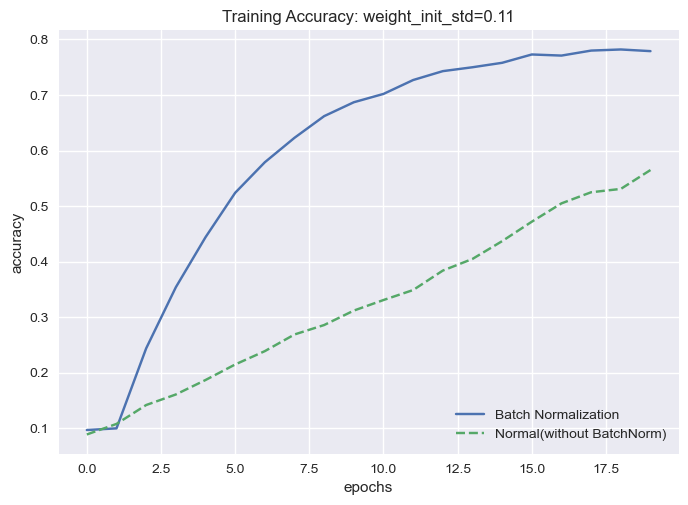

In [32]:
from dataset.mnist import load_mnist
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

weight_init_std = 0.11

def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            # print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list

train_acc_list, bn_train_acc_list = __train(weight_init_std)

# drawing
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 9}
import matplotlib
matplotlib.rc('font', **font)

x = np.arange(max_epochs)
plt.subplots()
plt.title('Training Accuracy: weight_init_std='+str(weight_init_std))
plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

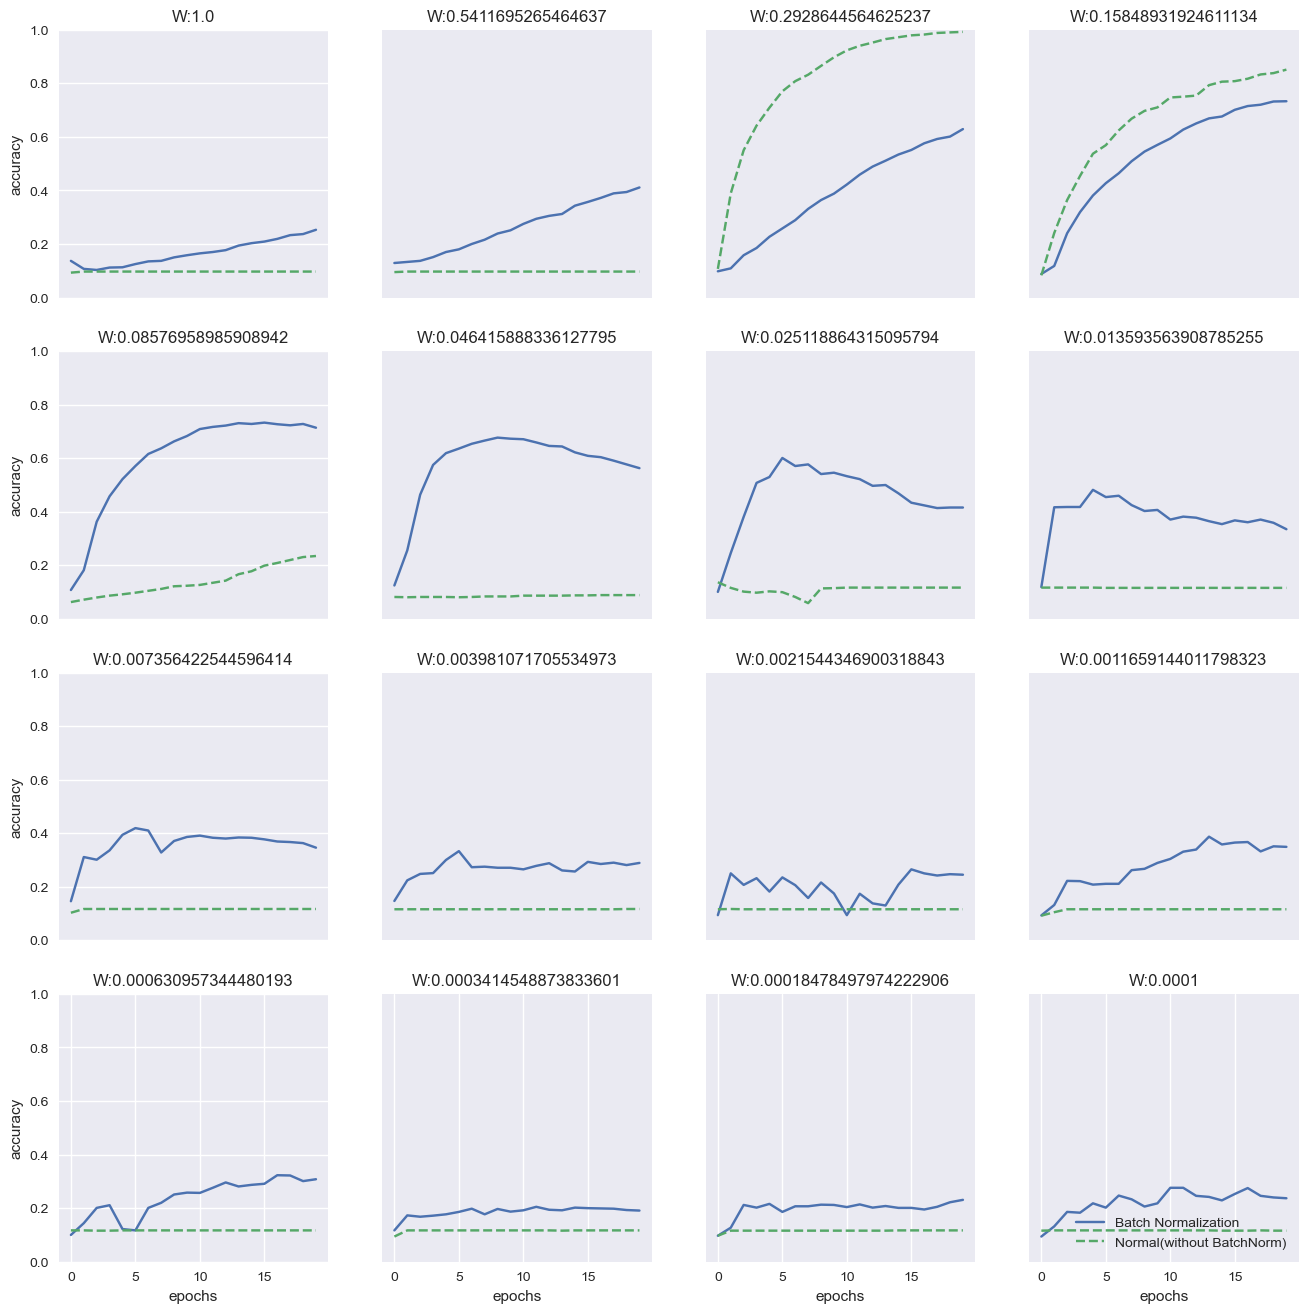

In [47]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            # print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 8}
import matplotlib
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(16, 16))

weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    # print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
        plt.legend(loc='lower right')
        
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    
plt.show()


## 4. 오버피팅, 오버피팅 방지책

주로 다음과 같은 경우 오버피팅이 발생한다.
- 매개변수가 많고 표현력이 높은 모델
- 훈련데이터가 적은 경우


오버피팅이 일어나는 이유는 훈련이 지나치면, 본질적인 핵심(ideal) 요소에 더하여 불필요한 부수적, 우연적, 개별적, 특수한, 지엽적 정보를 핵심요소로 학습해 버려서 새로운 정보에 대한 적응력이 떨어지기 때문이다.  
해결책으로 다음 두 가지 regularizations를 들 수 있다.
   1. 가중치 감소 기술
   2. 드롭아웃   

### 4.1 가중치 감소Weigt decay
오버피팅은 가중치 매개변수 값이 커서 발생하는 경우가 많으므로 상응하는 패널티를 부과하여 억제한다.
- 주로 $L^2$ regularization 을 사용한다.
   - 손실함수 $L$,
   - 매개변수 $\mathbf{W}$의 에너지 $\sum w_{ij}^2 \equiv \mathbf{W}^2$ 와
   - 정규화 세기 파라미터 $\lambda$에 대하여
$$
L \leftarrow L + \frac{1}{2}\lambda \mathbf{W}^2
$$
- 이 때, 데이터가 $\mathbf{W}$를 가지고 계산하는 Affine 층을 통과하는 횟수에 따라 누적합을 손실함수에 더해 준다.
- 따라서, gradient는 다음과 같다.
$$
\frac{\partial L}{\partial \mathbf{W}} + \lambda \mathbf{W}
$$  
- $L^1$ regularization: 새로운 손실함수 = 기존 손실함수 + $\lambda$(가중치 절대값의 합)  
- 기존 손실함수를 낮추는 것은 가중치가 데이터에 fitting하게 됨을 의미한다. 
- $L^2$ regularization은 큰 가중치는 많이 낮추고 작은 가중치는 적게 낮춘다.(동심원 contour그래프를 상상해보라.)
- $L^1$ regularization은 가중치를 동일하게 낮춰서 작은 가중치를 사라지게 한다.(다이아몬드 contour그래프를 상상해보라.)  
- 가중치 감소 계수 $\lambda$가 클 수록 penalty가 중요한 역할을 하게 되고 정보를 더 많이 잃게 된다. 반대로 작을 수록 불필요한 정보들이 살아 남게 되므로 적절한 수준으로 선택되어야 한다.  
- 
### 4.2 Dropout
신경망이 복잡해질 수록 가중치 감소만으로 대응하기 어려워진다. 이럴 때 흔히 드롭아웃기법을 사용한다.
- 드롭아웃 기법은 드롭아웃 모양에 대응하는 다른 여러 모델을 앙상블하는 것과 같은 효과를 낸다.
- `dropout_ratio` 비율만큼 신경망 노드를 사용하지 않고 훈련하게 되므로 
- `(1 - dropout_ratio)` 비율로 파라미터 전체를 scale down하여 test에 사용하는 것이 합리적이다.
- 그러나 이 비율을 곱하지 않아도 상관 없다고 한다.

In [34]:
# class MultiLayerNetExtended: 에서 쓰인 가중치 감소
# ...
def loss(self, x, t, train_flg=False):
       
    y = self.predict(x, train_flg)

    weight_decay = 0
    for idx in range(1, self.hidden_layer_num + 2):
        W = self.params['W' + str(idx)]
        weight_decay += 0.5*self.weight_decay_lambda*np.sum(W**2) # 누적합이라는 점에 유의

    return self.last_layer.forward(y, t) + weight_decay

def gradient(self, x, t):
    # ...
    grads = {}
    # ... Affine 층마다 가중치 감소가 적용된 gradient가 계산된다.
    grads['W'+str(idx)] = self.layers['Affine'+str(idx)].dW + self.weight_decay_lambda*self.params['W'+str(idx)]

In [35]:
class Dropout:
    def __init__(self, dropout_ratio=0.5) -> None:
        self.dropout_ratio = dropout_ratio
        self.mask = None
    def forward(self, w, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask